#### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

In [2]:
df = pd.read_csv('../../data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

#### Cleaning

In [34]:
#this removes float/int outliers
def remove_outlier(df):
    for x in df:
        q1 = df[x].quantile(0.25)
        q3 = df[x].quantile(0.75)
        iqr = q3-q1 #Interquartile range
        fence_low  = q1-1.5*iqr
        fence_high = q3+1.5*iqr
        df = df.loc[(df[x] > fence_low) & (df[x] < fence_high)]
    return df
#remove_outlier(df)

In [42]:
abs(df.corr()['price']).sort_values()

id               0.016772
long             0.022036
zipcode          0.053402
yr_built         0.053953
sqft_lot15       0.082845
sqft_lot         0.089876
yr_renovated     0.129599
floors           0.256804
lat              0.306692
bedrooms         0.308787
sqft_basement    0.321108
bathrooms        0.525906
sqft_living15    0.585241
sqft_above       0.605368
sqft_living      0.701917
price            1.000000
Name: price, dtype: float64

Drops: zipcode, id, long, yr_built, sqft_lot15, sqft_lot, yr_renovated, floors, lat. (maybe keep lat) 

Using price as a dependent variable. Assuming our stockholder is a real estate/brokerage company, TBD, who gets a commission on each sale or purchase. 

Keeping only variables with a correlation of at least .3.

In [44]:
df2 = df.drop(['zipcode', 'id', 'long', 'yr_built', 'sqft_lot15', 'sqft_lot', 'yr_renovated', 'floors', 'lat', 'sqft_basement'], axis=1)
df2
#Drop pythonically.

,date,price,bedrooms,bathrooms,sqft_living,waterfront,view,condition,grade,sqft_above,sqft_living15
0,10/13/2014,221900.0,3,1.00,1180,NaN,NONE,Average,7 Average,1180,1340
1,12/9/2014,538000.0,3,2.25,2570,NO,NONE,Average,7 Average,2170,1690
2,2/25/2015,180000.0,2,1.00,770,NO,NONE,Average,6 Low Average,770,2720
3,12/9/2014,604000.0,4,3.00,1960,NO,NONE,Very Good,7 Average,1050,1360
4,2/18/2015,510000.0,3,2.00,1680,NO,NONE,Average,8 Good,1680,1800
...,...,...,...,...,...,...,...,...,...,...,...
21592,5/21/2014,360000.0,3,2.50,1530,NO,NONE,Average,8 Good,1530,1530
21593,2/23/2015,400000.0,4,2.50,2310,NO,NONE,Average,8 Good,2310,1830
21594,6/23/2014,402101.0,2,0.75,1020,NO,NONE,Average,7 Average,1020,1020
21595,1/16/2015,400000.0,3,2.50,1600,NaN,NONE,Average,8 Good,1600,1410


#### Date

In [7]:
df2['date'] = pd.to_datetime(df2['date'], infer_datetime_format=True)
df2['date'] = df2['date'].dt.strftime('%Y-%m')
date_price = df2.filter(['date', 'price'])
date_price.head()

,date,price
0,2014-10,221900.0
1,2014-12,538000.0
2,2015-02,180000.0
3,2014-12,604000.0
4,2015-02,510000.0


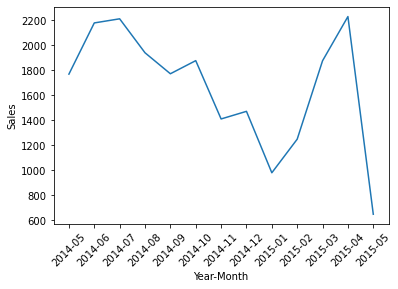

In [8]:
fig, ax = plt.subplots()
plt.xticks(rotation = 45)
ax.set_xlabel('Year-Month')
ax.set_ylabel('Sales')

ax.plot(date_price['date'].value_counts().sort_index());

In [9]:
date_avg_price = date_price.groupby(['date']).mean().sort_values(['date'])
date_avg_price.head()

,price
date,
2014-05,548166.600113
2014-06,557534.318182
2014-07,544892.161013
2014-08,536655.212481
2014-09,529723.517787


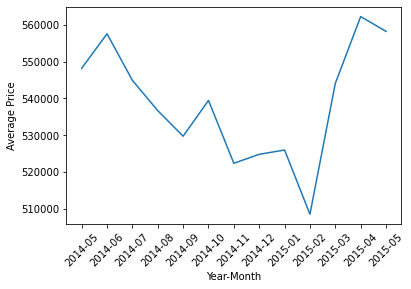

In [10]:
fig, ax = plt.subplots()
plt.xticks(rotation = 45)
ax.set_xlabel('Year-Month')
ax.set_ylabel('Average Price')

ax.plot(date_avg_price);

#### Categoricals

##### Grade and Price

In [11]:
category_df = df2.filter(['price', 'condition', 'grade'])
category_df.head()

,price,condition,grade
0,221900.0,Average,7 Average
1,538000.0,Average,7 Average
2,180000.0,Average,6 Low Average
3,604000.0,Very Good,7 Average
4,510000.0,Average,8 Good


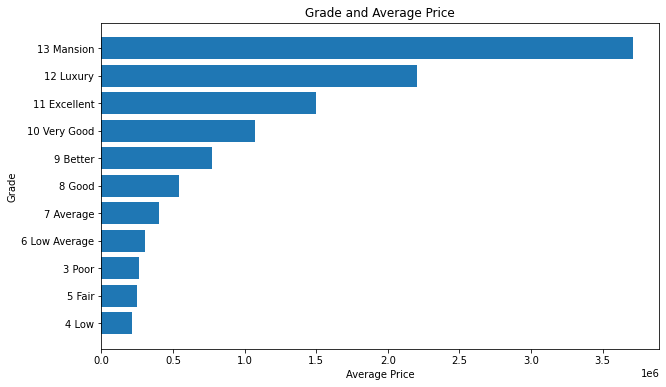

In [12]:
grade_vs_price = category_df.groupby(['grade']).mean().sort_values(['price'], ascending=False)

fig, ax = plt.subplots(figsize=(10,6))

ax.barh(y=grade_vs_price.index, width=grade_vs_price['price'])
ax.invert_yaxis()
ax.set_title('Grade and Average Price')
ax.set_ylabel('Grade')
ax.set_xlabel('Average Price');

In [13]:
category_df['grade'].value_counts()

7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

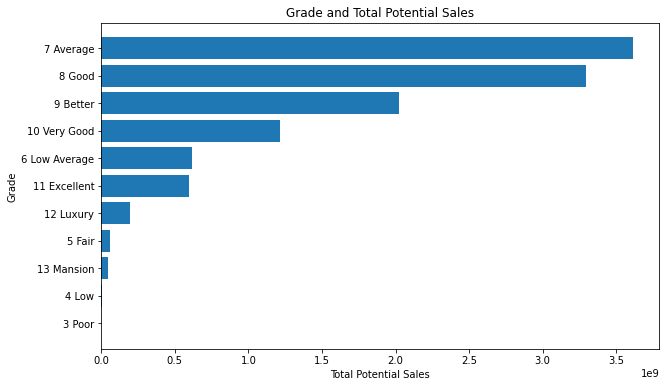

In [14]:
grade_vs_price = category_df.groupby(['grade']).sum().sort_values(['price'], ascending=False)

fig, ax = plt.subplots(figsize=(10,6))

ax.barh(y=grade_vs_price.index, width=grade_vs_price['price'])
ax.invert_yaxis()
ax.set_title('Grade and Total Potential Sales')
ax.set_ylabel('Grade')
ax.set_xlabel('Total Potential Sales');

Clearly the mansions sold for the most but there aren't many of them. They account for less of the total potential sales. 

In [15]:
grade_df = category_df.filter(['grade', 'price'])
grade_df.replace('13 Mansion', 13, inplace=True) 
grade_df.replace('12 Luxury', 12, inplace=True) 
grade_df.replace('11 Excellent', 11, inplace=True) 
grade_df.replace('10 Very Good', 10, inplace=True) 
grade_df.replace('9 Better', 9, inplace=True) 
grade_df.replace('8 Good', 8, inplace=True) 
grade_df.replace('7 Average', 7, inplace=True) 
grade_df.replace('6 Low Average', 6, inplace=True) 
grade_df.replace('5 Fair', 5, inplace=True) 
grade_df.replace('4 Low', 4, inplace=True) 
grade_df.replace('3 Poor', 3, inplace=True) 
grade_df.head()
#make function?

,grade,price
0,7,221900.0
1,7,538000.0
2,6,180000.0
3,7,604000.0
4,8,510000.0


In [16]:
stats.contingency.chi2_contingency(grade_df) 

(36879.129511544714,
 0.0,
 21596,
 array([[3.14516331e+00, 2.21903855e+05],
        [7.62535601e+00, 5.37999375e+05],
        [2.55128620e+00, 1.80003449e+05],
        ...,
        [5.69921331e+00, 4.02102301e+05],
        [5.66944929e+00, 4.00002331e+05],
        [4.60643464e+00, 3.25002394e+05]]))

In [17]:
formula = 'price ~ C(grade)'
lm = ols(formula, grade_df).fit()
sm.stats.anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(grade),10.0,1.515506e+15,1.515506e+14,2338.238311,0.0
Residual,21586.0,1.399076e+15,6.481403e+10,NaN,NaN


#### Regression Analysis 

In [18]:
formula = 'price ~ sqft_living'
model = ols(formula=formula, data=df2).fit()
model_summary = model.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.097e+04
Date:                Mon, 28 Mar 2022   Prob (F-statistic):               0.00
Time:                        12:27:20   Log-Likelihood:            -3.0006e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21595   BIC:                         6.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.399e+04   4410.023     -9.975      0.000   -5.26e+04   -3.53e+04
sqft_living   280.8630      1.939    144.819      0.000     277.062     284.664
==============================================================================
Omnibus:                    14801.942   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           542662.604
Skew:                           2.820   Prob(JB):                         0.00
Kurtosis:                      26.901   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
formula = 'price ~ bathrooms + sqft_living + sqft_above + sqft_living15 + bedrooms'
model = ols(formula=formula, data=df2).fit()
model_summary = model.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     4576.
Date:                Mon, 28 Mar 2022   Prob (F-statistic):               0.00
Time:                        12:27:20   Log-Likelihood:            -2.9959e+05
No. Observations:               21597   AIC:                         5.992e+05
Df Residuals:                   21591   BIC:                         5.992e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2.164e+04   7768.298      2.786      0.005    6417.601    3.69e+04
bathrooms      1.029e+04   3510.278      2.931      0.003    3408.151    1.72e+04
sqft_living     303.8065      4.854     62.591      0.000     294.293     313.320
sqft_above      -44.2576      4.503     -9.828      0.000     -53.084     -35.431
sqft_living15    68.7710      3.993     17.225      0.000      60.945      76.597
bedrooms       -5.71e+04   2342.723    -24.371      0.000   -6.17e+04   -5.25e+04
==============================================================================
Omnibus:                    15124.553   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           613612.122
Skew:                           2.878   Prob(JB):                         0.00
Kurtosis:                      28.470   Cond. No.                     1.66e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.66e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Jarque-Bera (JB) is high, skewness and kurtosis need to be addressed. In addition the high Condition number indicates there may be multicollinearity. 

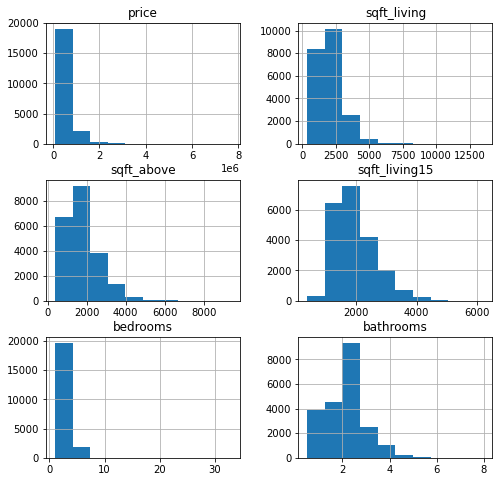

In [20]:
df2[['price', 'sqft_living', 'sqft_above', 'sqft_living15', 'bedrooms', 'bathrooms']].hist(figsize  = [8, 8]); 

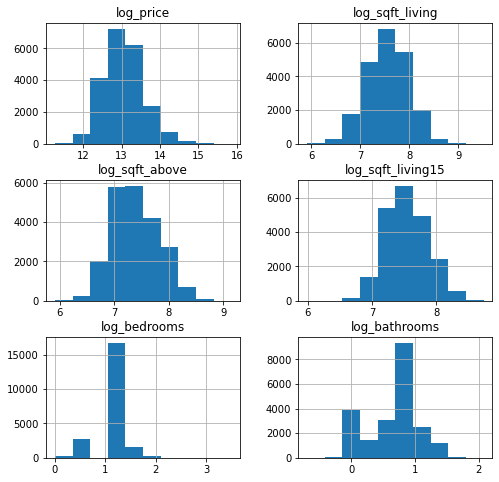

In [21]:
data_log = pd.DataFrame([])
data_log['log_price'] = np.log(df2['price'])
data_log['log_sqft_living'] = np.log(df2['sqft_living'])
data_log['log_sqft_above'] = np.log(df2['sqft_above'])
data_log['log_sqft_living15'] = np.log(df2['sqft_living15'])
data_log['log_bedrooms'] = np.log(df2['bedrooms'])
data_log['log_bathrooms'] = np.log(df2['bathrooms'])
data_log.hist(figsize  = [8, 8]);
#Create a function

In [22]:
formula = 'log_price ~ log_sqft_living'
model = ols(formula=formula, data=data_log).fit()
model_summary = model.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                 1.805e+04
Date:                Mon, 28 Mar 2022   Prob (F-statistic):               0.00
Time:                        12:27:20   Log-Likelihood:                -10231.
No. Observations:               21597   AIC:                         2.047e+04
Df Residuals:                   21595   BIC:                         2.048e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           6.7234      0.047    142.612      0.000       6.631       6.816
log_sqft_living     0.8376      0.006    134.368      0.000       0.825       0.850
==============================================================================
Omnibus:                      123.577   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              114.096
Skew:                           0.143   Prob(JB):                     1.68e-25
Kurtosis:                       2.787   Cond. No.                         137.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
formula = 'log_price ~ log_sqft_living + log_sqft_above + log_sqft_living15 + log_bedrooms + log_bathrooms'
model = ols(formula=formula, data=data_log).fit()
model_summary = model.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     4184.
Date:                Mon, 28 Mar 2022   Prob (F-statistic):               0.00
Time:                        12:27:20   Log-Likelihood:                -9475.5
No. Observations:               21597   AIC:                         1.896e+04
Df Residuals:                   21591   BIC:                         1.901e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             5.2855      0.077     68.461      0.000       5.134       5.437
log_sqft_living       0.7816      0.015     50.742      0.000       0.751       0.812
log_sqft_above       -0.0760      0.012     -6.230      0.000      -0.100      -0.052
log_sqft_living15     0.3594      0.012     29.834      0.000       0.336       0.383
log_bedrooms         -0.2683      0.012    -22.419      0.000      -0.292      -0.245
log_bathrooms         0.0443      0.010      4.386      0.000       0.024       0.064
==============================================================================
Omnibus:                      111.872   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              100.650
Skew:                           0.125   Prob(JB):                     1.39e-22
Kurtosis:                       2.779   Cond. No.                         399.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
data_log.corr()

,log_price,log_sqft_living,log_sqft_above,log_sqft_living15,log_bedrooms,log_bathrooms
log_price,1.000000,0.674802,0.586013,0.607154,0.342850,0.520278
log_sqft_living,0.674802,1.000000,0.864979,0.746836,0.648121,0.760764
log_sqft_above,0.586013,0.864979,1.000000,0.713102,0.546713,0.683889
log_sqft_living15,0.607154,0.746836,0.713102,1.000000,0.425690,0.570469
log_bedrooms,0.342850,0.648121,0.546713,0.425690,1.000000,0.534008
log_bathrooms,0.520278,0.760764,0.683889,0.570469,0.534008,1.000000


In [25]:
predictors = data_log.drop(['log_price'], axis=1)
predictors = predictors.corr().abs().stack().reset_index().sort_values(0, ascending=False)
predictors

,level_0,level_1,0
0,log_sqft_living,log_sqft_living,1.000000
6,log_sqft_above,log_sqft_above,1.000000
18,log_bedrooms,log_bedrooms,1.000000
12,log_sqft_living15,log_sqft_living15,1.000000
24,log_bathrooms,log_bathrooms,1.000000
1,log_sqft_living,log_sqft_above,0.864979
5,log_sqft_above,log_sqft_living,0.864979
20,log_bathrooms,log_sqft_living,0.760764
4,log_sqft_living,log_bathrooms,0.760764
10,log_sqft_living15,log_sqft_living,0.746836


In [26]:
predictors['pairs'] = list(zip(predictors.level_0, predictors.level_1))
predictors.set_index(['pairs'], inplace = True)
predictors.drop(columns=['level_1', 'level_0'], inplace = True)

In [27]:
predictors.columns = ['cc']

In [28]:
predictors.drop_duplicates(inplace=True)
predictors[(predictors.cc>.5) & (predictors.cc <1)]

,cc
pairs,
"(log_sqft_living, log_sqft_above)",0.864979
"(log_bathrooms, log_sqft_living)",0.760764
"(log_sqft_living15, log_sqft_living)",0.746836
"(log_sqft_living15, log_sqft_above)",0.713102
"(log_sqft_above, log_bathrooms)",0.683889
"(log_bedrooms, log_sqft_living)",0.648121
"(log_bathrooms, log_sqft_living15)",0.570469
"(log_sqft_above, log_bedrooms)",0.546713
"(log_bedrooms, log_bathrooms)",0.534008


In [29]:
formula = 'log_price ~ log_sqft_living + log_sqft_above + log_sqft_living15 + log_bedrooms + log_bathrooms'
model = ols(formula=formula, data=data_log).fit()
model_summary = model.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     4184.
Date:                Mon, 28 Mar 2022   Prob (F-statistic):               0.00
Time:                        12:27:20   Log-Likelihood:                -9475.5
No. Observations:               21597   AIC:                         1.896e+04
Df Residuals:                   21591   BIC:                         1.901e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             5.2855      0.077     68.461      0.000       5.134       5.437
log_sqft_living       0.7816      0.015     50.742      0.000       0.751       0.812
log_sqft_above       -0.0760      0.012     -6.230      0.000      -0.100      -0.052
log_sqft_living15     0.3594      0.012     29.834      0.000       0.336       0.383
log_bedrooms         -0.2683      0.012    -22.419      0.000      -0.292      -0.245
log_bathrooms         0.0443      0.010      4.386      0.000       0.024       0.064
==============================================================================
Omnibus:                      111.872   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              100.650
Skew:                           0.125   Prob(JB):                     1.39e-22
Kurtosis:                       2.779   Cond. No.                         399.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""